No artifacts
Spectrograms
Time coherence?
3 subjects, should be split?

In [1]:
import numpy as np
import pandas as pd
import biosppy

In [2]:
train_labels_csv = pd.read_csv('train_labels.csv')
train_eeg1_csv = pd.read_csv('train_eeg1.csv')
train_eeg2_csv = pd.read_csv('train_eeg2.csv')
train_emg_csv = pd.read_csv('train_emg.csv')

In [ ]:
train_eeg1_df = train_eeg1_csv.append(train_labels_csv)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
np.shape(train_labels_csv)

(64800, 2)

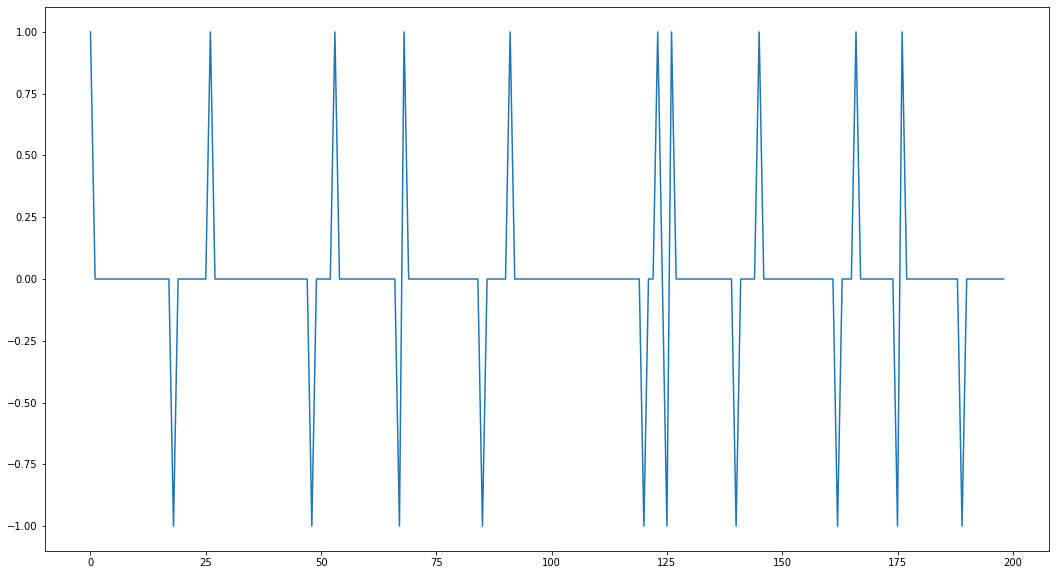

In [26]:
fig = plt.figure(figsize=(18, 10))
x = -1000
plt.plot(np.diff(train_labels_csv['y'].values[:21600][12000+x:12200+x]))
#plt.plot((train_labels_csv['y'].values[:21600]))
#plt.plot((train_labels_csv['y'].values[:21600]))
plt.show()

In [12]:
sample_csv = pd.read_csv('sample.csv')
test_eeg1_csv = pd.read_csv('test_eeg1.csv')
test_eeg2_csv = pd.read_csv('test_eeg2.csv')
test_emg_csv = pd.read_csv('test_emg.csv')

In [12]:
train1 = train_eeg1_csv[train_labels_csv.y==1]
train2 = train_eeg1_csv[train_labels_csv.y==2]
train3 = train_eeg1_csv[train_labels_csv.y==3]


In [9]:
train1.iloc[300][]

Id      556.000000
x1       -0.000034
x2       -0.000240
x3        0.000057
x4        0.000420
           ...    
x508      0.000010
x509      0.000015
x510      0.000037
x511     -0.000086
x512     -0.000310
Name: 556, Length: 513, dtype: float64

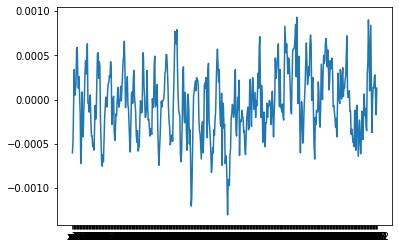

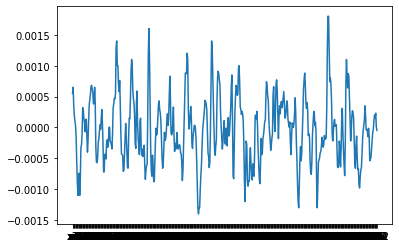

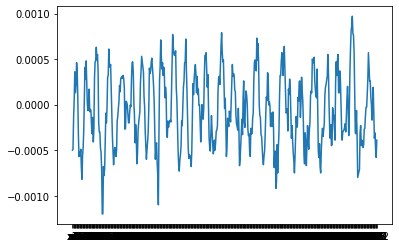

In [13]:
plt.plot(train1.iloc[20][2:])
plt.show()
plt.plot(train2.iloc[20][2:])
plt.show()
plt.plot(train3
         .iloc[20][2:])
plt.show()